## Searches Forecast

### Environment Setup

In [ ]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [ ]:
## Import Dataset
searches = pd.read_csv(r"/content/searches.csv")

### Initial Exploration

In [ ]:
## General Information on dataset
print(searches.describe(include='all'))
print('\nUnique GEOS in Dataset ' + str(searches.GEO.unique()))
print('Unique YEARS in Dataset ' + str(searches['DATEPART'].apply(lambda x: x[:4]).unique()))

          DATEPART            GEO  PHRASE   TOTAL_EVENTS
count       837381  837381.000000  837381  837381.000000
unique        1871            NaN     100            NaN
top     2020-11-24            NaN  family            NaN
freq           565            NaN   10054            NaN
mean           NaN       4.477676     NaN      33.063383
std            NaN       1.737018     NaN     120.185266
min            NaN       1.000000     NaN       1.000000
25%            NaN       3.000000     NaN       4.000000
50%            NaN       5.000000     NaN      11.000000
75%            NaN       6.000000     NaN      33.000000
max            NaN       7.000000     NaN   12074.000000

Unique GEOS in Dataset [5 4 3 6 7 1 2]
Unique YEARS in Dataset ['2021' '2019' '2018' '2020' '2017' '2022']


In [ ]:
## How many rows do we have for each GEO/location. Are they evenly spread out?
searches.groupby(['GEO'])['TOTAL_EVENTS'].count()

GEO
1     81788
2        14
3    160706
4    168830
5    173283
6    125468
7    127292
Name: TOTAL_EVENTS, dtype: int64

This shows that the data is evenly spread out for the most geographies except for location#2 where we only have 14 records. We will remove this location from our analysis in data cleaning process later because eventually we want to build a forecast model for each location and each phrase in it separately. This location having too few a datapoints won't be enough for a valid forecast.

In [ ]:
## How many phrases do we have for each location?
searches.groupby(['GEO'])['PHRASE'].nunique()

GEO
1    100
2      7
3    100
4    100
5    100
6    100
7    100
Name: PHRASE, dtype: int64

Looks like except for location#2 which we want to leave out anyway, rest of the locations have consistent number of unique phrases as per our dataset i.e. 100. We'll now quickly confirm if these phrases are the same or mutually exclusive across geographies. Looks like we might have the same phrases because overall unique phrases in the given dataset is also 100 as checked earlier.

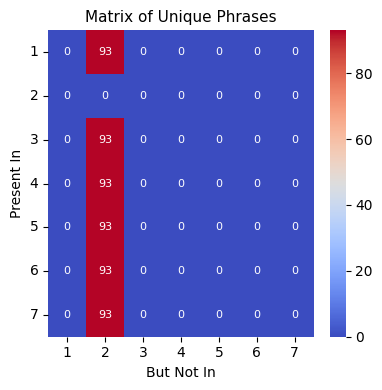

In [ ]:
## Matrix to explain which phrases do not exist in which geography
matrix_df = pd.DataFrame(0, index=range(1, 8), columns=range(1, 8), dtype=int)

# Iterate through each combination of geographies and calculate the count of unique phrases
for i in range(1, 8):
    for j in range(1, 8):
        if i != j:
            unique_phrases_i = set(searches[searches['GEO'] == i]['PHRASE'].unique())
            unique_phrases_j = set(searches[searches['GEO'] == j]['PHRASE'].unique())
            count_unique_phrases_not_in_j = len(unique_phrases_i - unique_phrases_j)
            matrix_df.at[i, j] = count_unique_phrases_not_in_j

# Now that the matrix is created
# Create the heatmap for better visuals
plt.figure(figsize=(4, 4))
sns.heatmap(matrix_df, cmap='coolwarm', annot=True, fmt='d', annot_kws={"size": 8})
plt.xlabel('But Not In', fontsize=10)
plt.ylabel('Present In', fontsize=10)
plt.title('Matrix of Unique Phrases', fontsize=11)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

We can confirm that all of the geographies have the same phrases in our dataset. 93 absentees in geography#2 is already established and understood. This means even if we want to compare results for any phrase across geographies, we can do that as well. But that is out of scope of our EDA. I only ran this check to better understand how the dataset is distributed and what filters (if any) were applied on it before it was shared. Now, we understand it has been filtered by these 100 keywords specifically.

### Data Cleaning & Feature Engineering

In [ ]:
## We'll remove geography#2 from the dataset due to aforementioned rationale
searches = searches[searches['GEO'] != 2]

In [ ]:
## Create month, week and year features to test out multiple aggregations later
searches['DATEPART'] = pd.to_datetime(searches['DATEPART']) ## Convert datatype from str -> datetime
searches['YEAR'] = searches['DATEPART'].dt.year
searches['WEEK'] = searches['DATEPART'].dt.isocalendar().week

# Create a new column 'YEAR_WEEK' in the format 'YYYY_WW for aggregations'
searches['YEAR_WEEK'] = searches['YEAR'].astype(str) + '_' + searches['WEEK'].astype(str).str.zfill(2)

# Group the data on weekly level for each geography further analyses and forecasts
## At this point we will lose the dimension of PHRASE as well because the forecasts
## we want to build will be one for each geography
searches_grouped = searches.groupby(['YEAR_WEEK', 'GEO']).aggregate({'TOTAL_EVENTS': 'sum', 'YEAR': 'mean', 'WEEK': 'mean'}).reset_index()
searches_grouped

,YEAR_WEEK,GEO,TOTAL_EVENTS,YEAR,WEEK
0,2017_01,1,185,2017.0,1.0
1,2017_01,3,6757,2017.0,1.0
2,2017_01,4,14490,2017.0,1.0
3,2017_01,5,15581,2017.0,1.0
4,2017_01,6,1797,2017.0,1.0
...,...,...,...,...,...
1615,2022_52,3,2120,2022.0,52.0
1616,2022_52,4,4407,2022.0,52.0
1617,2022_52,5,2023,2022.0,52.0
1618,2022_52,6,371,2022.0,52.0


We chose to aggregate the data on a weekly level to achieve automatic smoothing and reduce daily noise. Monthly aggregation could lead to data loss, while weekly offers a balance of granularity with 60 data points per year. (Golilocks' soup principle)

### Time Interpolation

Before running any EDA for the time-series, we want to have a row, for each phrase in each geo, for all weeks between 2017_01 and 2022_52. If the search has not been made on a given week, we want to impute 0 in it, so the gaps between the datapoints of time-series are consistent i.e. no irregular intervals

In [ ]:
## Create a DataFrame with all possible combinations of GEO and YEAR_WEEK
unique_geos = searches['GEO'].unique()
all_combinations = pd.DataFrame([(geo, year_week) for geo in unique_geos
                                 for year_week in pd.date_range(start='2017-01-01', end='2022-12-31', freq='W').strftime('%Y_%U')],
                                columns=['GEO', 'YEAR_WEEK'])

## Join this 'all_combinations' dataframe with original 'searches_grouped' dataframe to fetch record in the format we want
searches_final_df = pd.merge(all_combinations, searches_grouped, how='left', on=['GEO', 'YEAR_WEEK'])
searches_final_df['TOTAL_EVENTS'].fillna(0, inplace=True) ## Fill target (TOTAL_EVENTS) = 0  for where we have no join (no record)

searches_final_df['YEAR'] = searches_final_df['YEAR_WEEK'].apply(lambda x: x[:4])   ## Fix the YEAR field again
searches_final_df['WEEK'] = searches_final_df['YEAR_WEEK'].apply(lambda x: x[5:7])  ## Fix the WEEK field again
searches_final_df

,GEO,YEAR_WEEK,TOTAL_EVENTS,YEAR,WEEK
0,5,2017_01,15581.0,2017,01
1,5,2017_02,23281.0,2017,02
2,5,2017_03,29242.0,2017,03
3,5,2017_04,25262.0,2017,04
4,5,2017_05,23867.0,2017,05
...,...,...,...,...,...
1873,1,2022_48,0.0,2022,48
1874,1,2022_49,0.0,2022,49
1875,1,2022_50,0.0,2022,50
1876,1,2022_51,0.0,2022,51


### Time-Series exploratory data analysis

#### a. Visual Inspection

In [ ]:
searches_final_df

,GEO,YEAR_WEEK,TOTAL_EVENTS,YEAR,WEEK
0,5,2017_01,15581.0,2017,01
1,5,2017_02,23281.0,2017,02
2,5,2017_03,29242.0,2017,03
3,5,2017_04,25262.0,2017,04
4,5,2017_05,23867.0,2017,05
...,...,...,...,...,...
1873,1,2022_48,0.0,2022,48
1874,1,2022_49,0.0,2022,49
1875,1,2022_50,0.0,2022,50
1876,1,2022_51,0.0,2022,51


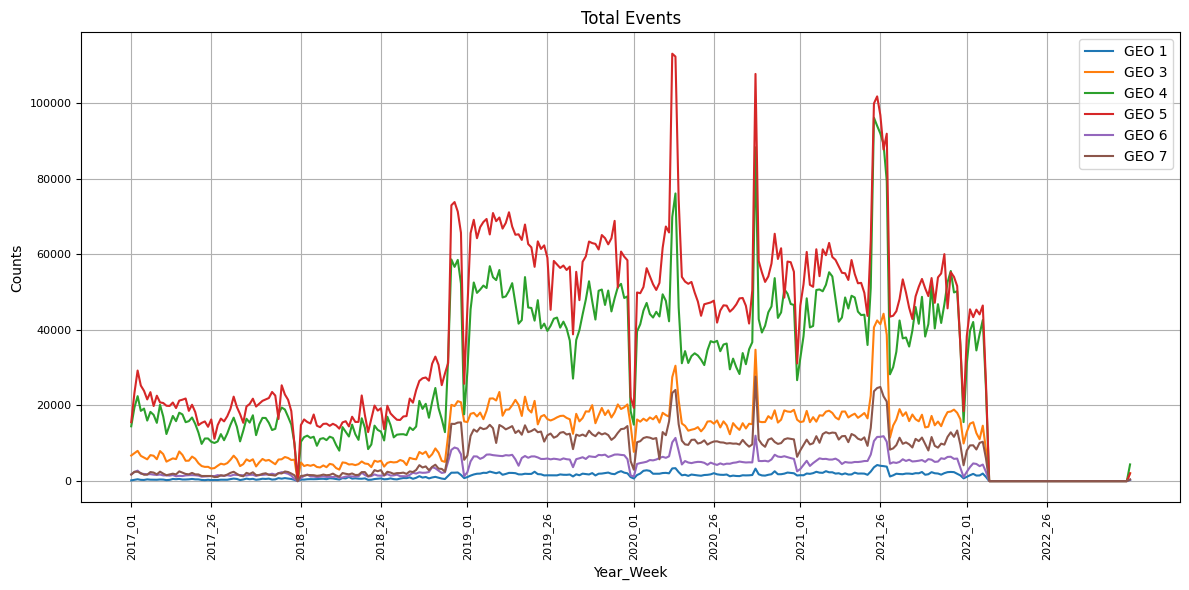

In [ ]:
## Plot the time-series for each geography for visual inspection

# Create the line plot for all GEOs by calling the function for
# each GEO in GEOs. I have sorted them for a neat looking legend
plt.figure(figsize=(12, 6))
for geo in sorted(searches_final_df['GEO'].unique()):
    plt.plot('YEAR_WEEK', 'TOTAL_EVENTS', data=searches_final_df[searches_final_df['GEO']==geo], label=f'GEO {geo}')

# Set labels and title
plt.xlabel('Year_Week', fontsize=10)
plt.ylabel('Counts', fontsize=10)
plt.title('Total Events', fontsize=12)

# Set the x-axis ticks to show specific intervals to avoid noisy x-axis. Wasn't feasible to have it for all weeks
x_ticks = ['2017_01', '2017_26', '2018_01', '2018_26', '2019_01', '2019_26', '2020_01', '2020_26', '2021_01', '2021_26', '2022_01', '2022_26']
plt.xticks(ticks=x_ticks, rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

#### b. Explanation around the nature of our time-series analysis

There seems to be obvious overall trend that all of the locations are following, which is good because we can build a single model and produce 'multiple univariate time-series forecasts'. This is different from 'multi-variate forecasting' because we don't have a case where multiple features (time-series) are being used to forecast one target (time-series). We have multiple independent time-series, for which we want independent forecasts. However, these time-series do have similar trends which we'll leverage using a single LSTM (long short term memory) model. We won't need multiple models (with different hyperparameters)

#### c. Why LSTM
My choice by simply looking at these time-series is LSTM. Though we have other options as mentioned below, which we'll go through one-by-one to explain why didn't I chose them.

1. classical methods i.e. ARIMA or SARIMA
2. off-the-shelf i.e. PROPHET
3. deep learning i.e. RNN

***1. classical methods i.e. ARIMA or SARIMA***:
ARIMA and SARIMA are classical/statiscal methods which are effective but they require the time-series to be stationary i.e. constant mean, constant variance. Normally if the time-series would look stationary upon visual inspection, it is interesting to decompose it into trend, seasonality and error components and check for it's stationality using AD Fuller tests etc. But just by looking at these time-series we can see these time-series do not have constant mean. The 'mean' changes around start of 2019 drastically. 'Variance' also change around the same time as well. SARIMA is also out of equation because of the same reasons and also we don't see any seasonality in the data atleast visually. There are one-offs but they are more of outliers.

***2. off-the-shelf i.e. PROPHET***:
Facebook's Prophet is a solid off-the-shelf option, but for our work, where we want multiple univariate forecasts, Prophet isn't a viable option. It is because we will have to build 6 independent models if we go with Prophet. This essentially means we won't be able to leverage overall patterns of one time-series for the other - which is something we want because we do see an overall pattern.

***3. deep leaning i.e. RNN***
RNN is a good alternate for our problem and have lighter architecture than LSTM, but with RNN we need to be careful about exploding or vanishing gradient. I would have considered using it if we had many more time-series to predict simultaneously and needed a lighter, less computationally expensive model.

***our choice: LSTM***
Our choice LSTM, though is computationally expensive, but is very versatile and can capture trends and patterns of complex nature (varying mean after some time etc). It is ideal for such problems and will work really nicely without smoothening or any other major pre-processing steps. It also doesn't require the time-series to be stationary. I also chose this because LSTM has many hyperparameters that we can tune later to drive incrementally better performance. For now, however, our goal is to get a base model and using LSTM with mainly default settings can outperform rest listed. It is a good first step for us to see if we can predict the volumes for these searches for each geography - which was the main question of the Leadership team.

#### d. Our Time-series have Different Scales

We have observed that due to the scale being different for these series i.e different volume in different locations, patterns for the locations with less volumes aren't very clear with the above-shared graph. We will plot again using independent y-axis to see if the overall trends and patterns are actually similar. Once we'll confirm, we can then choose to min-max scale each time-series before building one model for all series.


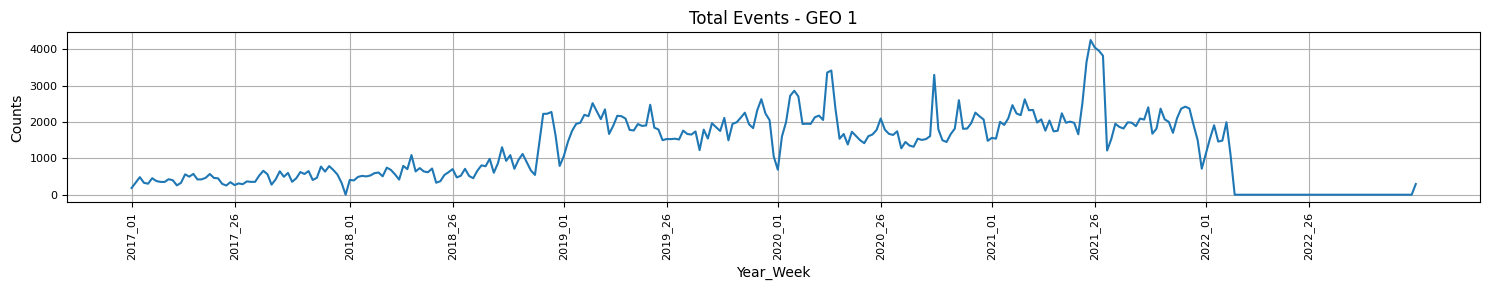

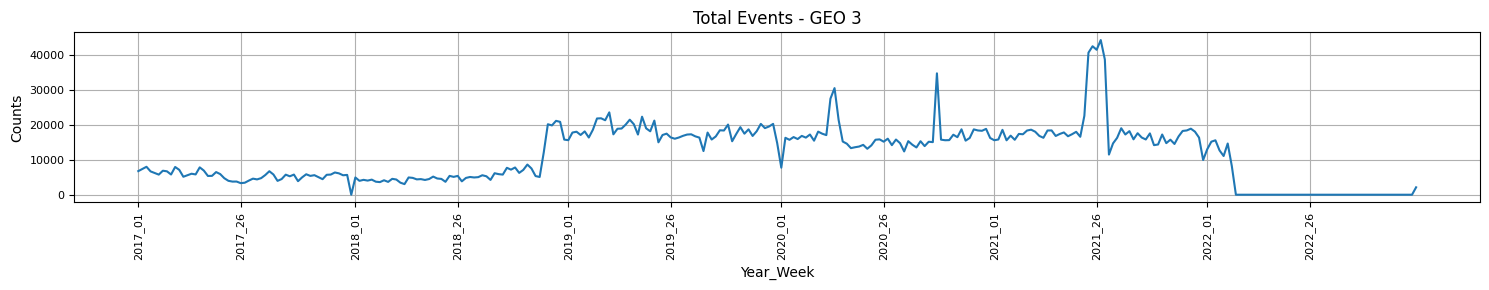

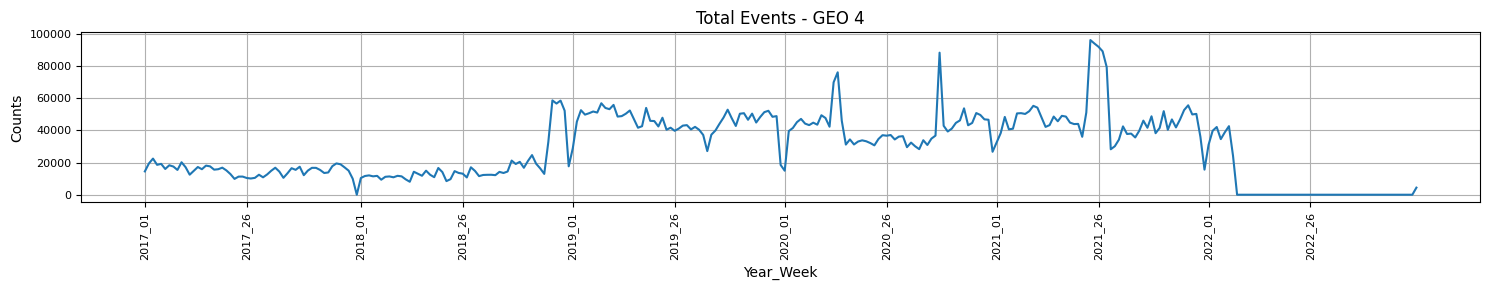

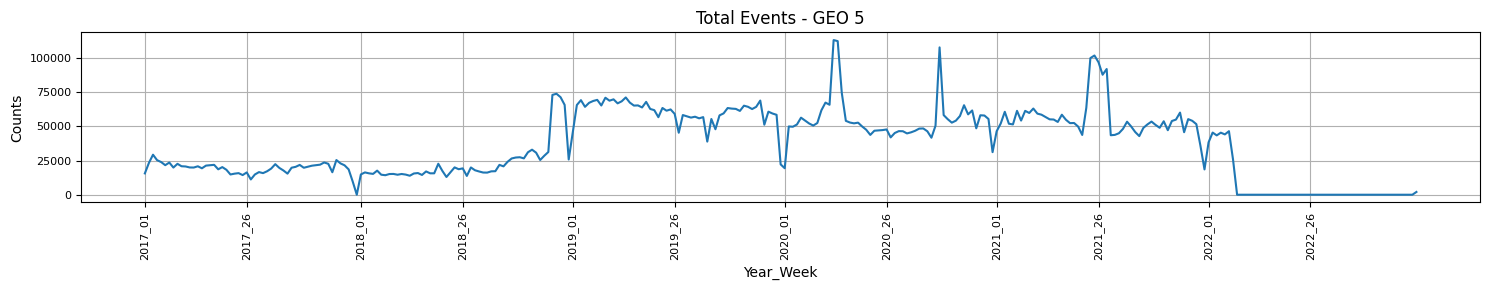

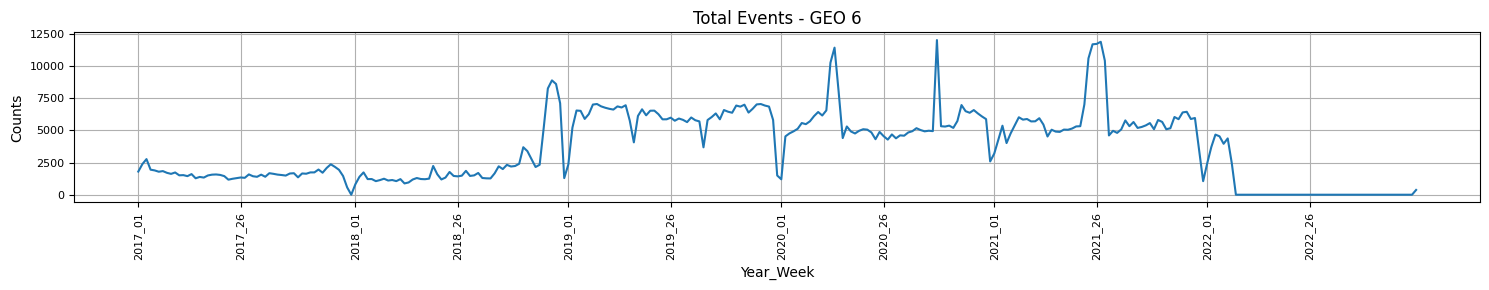

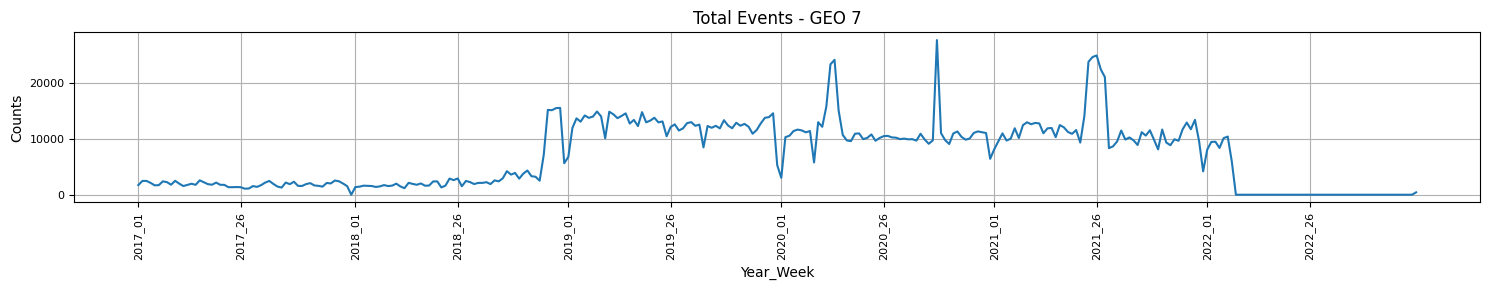

In [ ]:
# Function to create the line plot for each GEO
def line_plot_independent(data, geo):
    geo_weekly = data[data['GEO'] == geo].groupby(['YEAR_WEEK']).aggregate({'TOTAL_EVENTS': 'sum', 'YEAR': 'mean', 'WEEK': 'mean'}).reset_index()

    plt.figure(figsize=(15, 3))
    plt.plot('YEAR_WEEK', 'TOTAL_EVENTS', data=geo_weekly)

    plt.xlabel('Year_Week', fontsize=10)
    plt.ylabel('Counts', fontsize=10)
    plt.title(f'Total Events - GEO {geo}', fontsize=12)

    # Set the x-axis ticks to show specific intervals for clean looks
    x_ticks = ['2017_01', '2017_26', '2018_01', '2018_26', '2019_01', '2019_26', '2020_01', '2020_26', '2021_01', '2021_26', '2022_01', '2022_26']
    plt.xticks(ticks=x_ticks, rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.grid(True)
    plt.tight_layout()

# Get unique GEO values
unique_geos = sorted(searches_final_df['GEO'].unique())

# Loop through each GEO and create the line plot
for geo in unique_geos:
    line_plot_independent(searches_final_df, geo)
    plt.show()

Conclusions and Insights:

1. The trends, dips and overall patterns align for each geography which is inline with our initial hypothesis about the data. There is another consistent pattern we can see across all geographics i.e. somewhere around end of first quarter of 2022, we don't have any data. In the latter stages, we will remove this part before forecasting data for 24 months or 104 weeks.
2. The change in overall volume is consistent across all geographies during the last quarter of 2018. Also, the one-offs are consistent too e.g. once during the first wave of COVID in first half of 2020 and once during second half of 2020. Other shoot-offs are also consistent.

#### e. Did any specific phrases caused these shoot-offs that are consistent across regions?

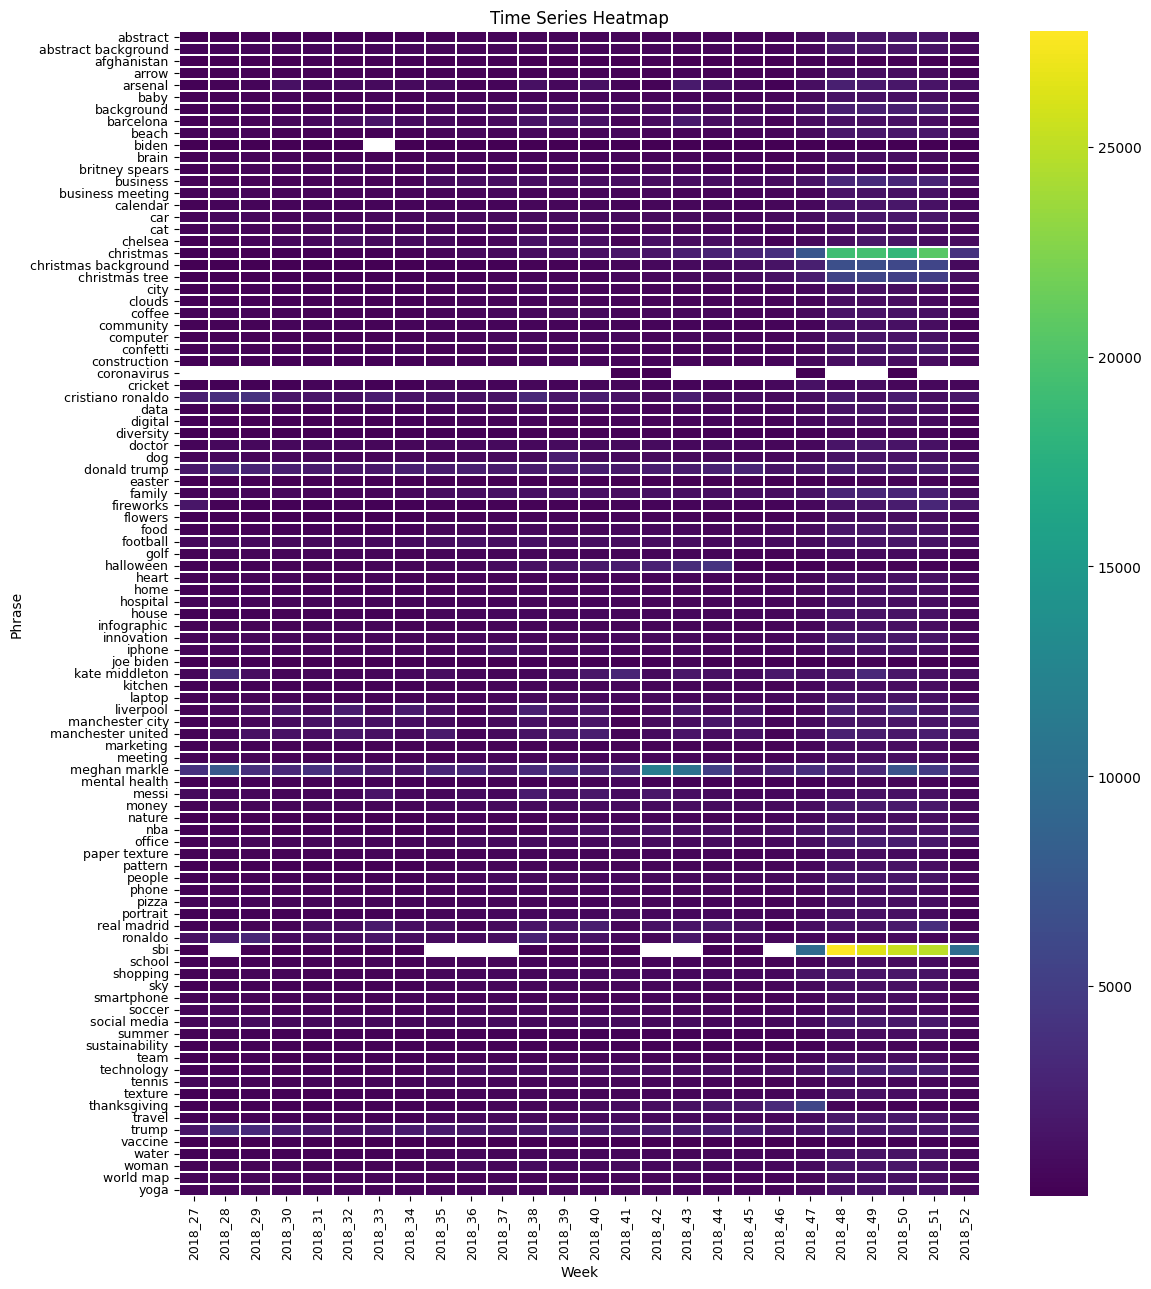

In [ ]:
## What happened during end of 2018?
phrases_ = searches.groupby(['YEAR_WEEK', 'PHRASE']).aggregate({'TOTAL_EVENTS': 'sum', 'YEAR': 'mean', 'WEEK': 'mean'}).reset_index()
segment_1 = phrases_.loc[(phrases_['YEAR']>=2018) & (phrases_['YEAR']<2019) & (phrases_['WEEK']> 26)].reset_index(drop=True)
heatmap_data = segment_1.pivot(index='PHRASE', columns='YEAR_WEEK', values='TOTAL_EVENTS')
heatmap_data = heatmap_data.sort_index(axis=1)

# Create the heatmap using seaborn
plt.figure(figsize=(12, 13))
sns.heatmap(heatmap_data, cmap='viridis', linewidths=0.1, linecolor='white', cbar=True, yticklabels=1)

# Set labels and title
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
plt.xlabel('Week', fontsize=10)
plt.ylabel('Phrase', fontsize=10)
plt.title('Time Series Heatmap', fontsize=12)

plt.tight_layout()
plt.show()

We can see people searched for SBI in this duration when the massive fraud reports came out:
<br> https://economictimes.indiatimes.com/industry/banking/finance/banking/sbi-reports-1329-fraud-cases-worth-rs-5555-crore-in-april-september-2018/articleshow/66139270.cms?from=mdr
<br> <br>
Search volumes for 'Christmas' phrase also went up during the same time for some reason. We can see how searches for 'CoronaVirus' were almost non-existant for the whole year. Similarly, we can check for other one-offs as well, which I would have loved to look into if I had more time.

### Data Manipulation

2022_07 is the last week for which we had the data. After this the volume dropped to 0 for the rest of the year. It did show a non-zero number for the last week but we will remove all of this dataset. We will also exclude the last week i.e. 2022_07 because the counts look smaller than the recent average, which hints
towards the fact that the issue with the data might have started sometime during the week.
(We can confirm it by looking at the raw dataset but no need to do that right now as we can simply exclude this one week as well)

In [ ]:
searches_final_df_trimmed = searches_final_df[~((searches_final_df['YEAR'].astype(int) == 2022) & (searches_final_df['WEEK'].astype(int) >= 7))]
searches_final_df_trimmed = searches_final_df_trimmed.reset_index(drop=True)
searches_final_df_trimmed

,GEO,YEAR_WEEK,TOTAL_EVENTS,YEAR,WEEK
0,5,2017_01,15581.0,2017,01
1,5,2017_02,23281.0,2017,02
2,5,2017_03,29242.0,2017,03
3,5,2017_04,25262.0,2017,04
4,5,2017_05,23867.0,2017,05
...,...,...,...,...,...
1597,1,2022_02,1544.0,2022,02
1598,1,2022_03,1908.0,2022,03
1599,1,2022_04,1460.0,2022,04
1600,1,2022_05,1486.0,2022,05


Now that we have dropped the incomplete data. We will now scale each time-series using min-max scaler. Though we will do it during model building as well but I wanted to do it on dataset level, but I wanted to visualise target before actually building a forecaster/model for it

In [ ]:
scaled_df = pd.DataFrame()
for geo in searches_final_df_trimmed['GEO'].unique():
    scaler = MinMaxScaler()
    geo_data = searches_final_df_trimmed[searches_final_df_trimmed['GEO'] == geo].copy()
    geo_data['TOTAL_EVENTS_SCALED'] = scaler.fit_transform(geo_data['TOTAL_EVENTS'].values.reshape(-1, 1))
    scaled_df = pd.concat([scaled_df, geo_data])

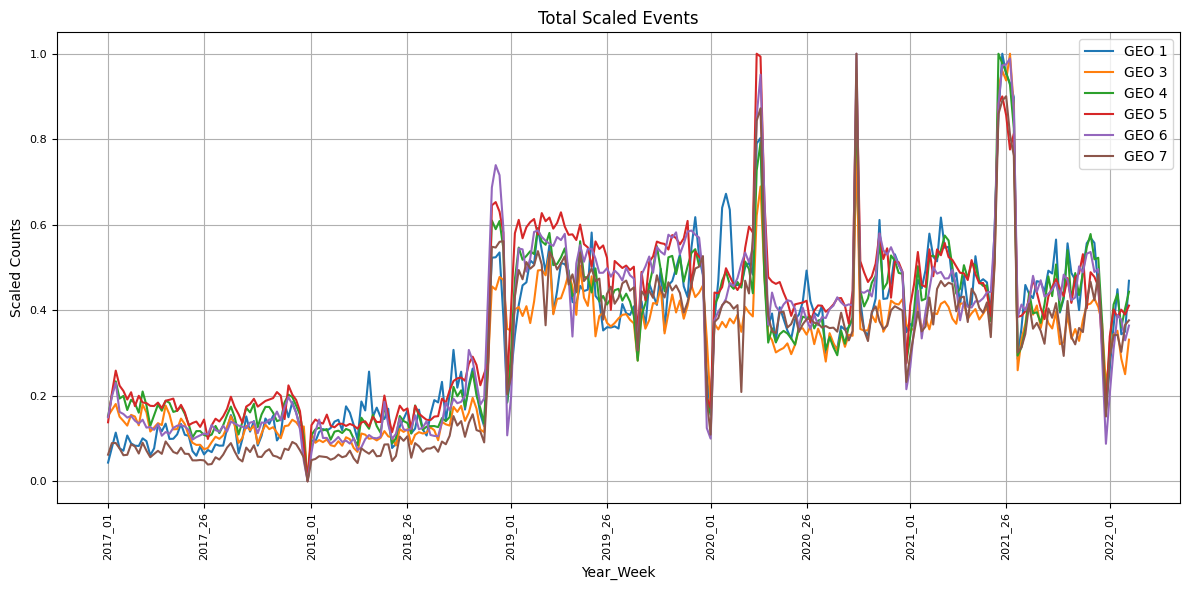

In [ ]:
## Plot the time-series for each geography for visual inspection after scaling

# Create the line plot for all GEOs by calling the function for
# each GEO in GEOs. I have sorted them for a neat looking legend
plt.figure(figsize=(12, 6))
for geo in sorted(scaled_df['GEO'].unique()):
    plt.plot('YEAR_WEEK', 'TOTAL_EVENTS_SCALED', data=scaled_df[scaled_df['GEO']==geo], label=f'GEO {geo}')

# Set labels and title
plt.xlabel('Year_Week', fontsize=10)
plt.ylabel('Scaled Counts', fontsize=10)
plt.title('Total Scaled Events', fontsize=12)

# Set the x-axis ticks to show specific intervals to avoid noisy x-axis. Wasn't feasible to have it for all weeks
x_ticks = ['2017_01', '2017_26', '2018_01', '2018_26', '2019_01', '2019_26', '2020_01', '2020_26', '2021_01', '2021_26', '2022_01']
plt.xticks(ticks=x_ticks, rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

Target looks good and ready to be forecasted

### Forecasting Model

In [ ]:
scaled_df.describe()

,GEO,TOTAL_EVENTS,TOTAL_EVENTS_SCALED,GEO_MIN,GEO_MAX
count,1602.000000,1602.000000,1602.000000,1602.0,1602.000000
mean,4.333333,17198.244070,0.334788,0.0,49547.333333
std,1.972642,19598.225177,0.192294,0.0,41177.332379
min,1.000000,0.000000,0.000000,0.0,4248.000000
25%,3.000000,2236.750000,0.144659,0.0,12006.000000
50%,4.500000,10458.500000,0.366691,0.0,35947.500000
75%,6.000000,20271.750000,0.465631,0.0,96106.000000
max,7.000000,113029.000000,1.000000,0.0,113029.000000


#### a. Model Training

1. This pipeline takes in 16 data points - each data point for one week - (i.e. 4 months) and based on these predicts next 4 weeks i.e. 1 month.
2. It does so for each GEO exlcluding #2 which we had removed from our analysis
3. It also runs K-fold validations with k=5, so we have 4(weeks)x5(folds)x6(GEOs)=120 records in the prediction dataframe
4. We save this model as well, so we can use if we like it during the model validation phase

WARNING: This step would take some 15 minutes as we are training with epoch=40 and we have to predict for 6 time-series with 5 folds.

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from math import sqrt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

# Function to create sequences from the data
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# Function to scale train and test data to [-1, 1]
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# Function to fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# Function to make a one-step forecast
def forecast_lstm(model, batch_size, X, n_ahead):
    yhat = []
    for _ in range(n_ahead):
        X = X.reshape(1, 1, len(X))
        fc = model.predict(X, batch_size=batch_size)
        if fc.shape == (1, 1):
            yhat.append(fc[0,0])
            X = np.append(X[0][0][1:], fc[0])
        else:
            yhat.append(fc)
            X = np.append(X[0][0][1:], fc)
    return yhat

# Function to make predictions for each GEO in the test set during cross-validation
def predict_for_test_set(lstm_model, df, test, scaler, sequence_length, fold_number):
    predictions = []
    for geo in df['GEO'].unique():
        geo_data = df[df['GEO'] == geo]['TOTAL_EVENTS'].values
        geo_scaler = MinMaxScaler(feature_range=(-1, 1))
        geo_scaler = geo_scaler.fit(geo_data.reshape(-1, 1))
        geo_scaled = geo_scaler.transform(geo_data.reshape(-1, 1))

        X_test = geo_scaled[-sequence_length:]
        yhat = forecast_lstm(lstm_model, batch_size=1, X=X_test, n_ahead=4)
        yhat = np.array(yhat).reshape(-1, 1)
        yhat_inverted = geo_scaler.inverse_transform(np.array(yhat))

        ### This block of code collects actuals and predicted values
        ### and put in a dataframe for evaluation for each GEO
        actuals = geo_data[-4:]
        for i in range(len(yhat_inverted)):
            predictions.append([geo, yhat_inverted[i][0], actuals[i], fold_number])
        ###
    return predictions

# Set the sequence length for us fix how many weeks do we want to look back while forecasting
sequence_length = 16

# Prepare data as supervised learning problem
supervised_values = timeseries_to_supervised(scaled_df['TOTAL_EVENTS'].values, sequence_length).values

# Set the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
fold_predictions = []

fold_number = 1

for train_idx, test_idx in kf.split(supervised_values):
    train, test = supervised_values[train_idx], supervised_values[test_idx]
    scaler, train_scaled, test_scaled = scale(train, test)
    lstm_model = fit_lstm(train_scaled, batch_size=1, nb_epoch=40, neurons=4)
    fold_predictions.extend(predict_for_test_set(lstm_model, scaled_df, test, scaler, sequence_length, fold_number))
    fold_number += 1 ## for each ieration

# Create a DataFrame with predictions for each GEO across all folds - to be used for model evaluation
predictions_df = pd.DataFrame(fold_predictions, columns=['GEO', 'Predicted', 'Actual', 'Fold'])

# Save each trained model for forecasting
lstm_model.save('trained_lstm_model.h5')

1/1 [==============================] - 0s 25ms/step


#### b. Model Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(geo):
    return sqrt(mean_squared_error(geo['Actual'], geo['Predicted']))

rmse_df = predictions_df.groupby(['GEO', 'Fold']).apply(rmse).reset_index(name='RMSE')
rmse_df = rmse_df.pivot_table(index='GEO', values='RMSE', columns= 'Fold').reset_index()

print('RMSE for each fold for each GEO')
print(rmse_df)

print(scaled_df.groupby('GEO')['TOTAL_EVENTS'].std().reset_index(name='Standard Deviation'))


RMSE for each fold for each GEO
Fold  GEO            1            2            3             4            5
0       1   266.710832   300.029167   162.154820    233.127570   277.521540
1       3  3011.157090  2004.264751  2544.200261   4708.211856  2961.635923
2       4  8412.931132  7104.390253  6895.596430  10347.758358  9825.382942
3       5  4626.312589  1416.480432  2558.307382   4741.587091  3679.751040
4       6   822.275688   756.690249   703.427427   1036.375639   682.573337
5       7  1532.362274  1902.545940  1621.722810   2274.155655  2094.223176
   GEO  Standard Deviation
0    1          817.787750
1    3         7364.628611
2    4        17859.593104
3    5        21567.661189
4    6         2458.899123
5    7         5502.732442


***Conclusion*** Our RMSEs are significantly lower than Standard Deviation of the target variable for each fold which means our model accounts for most variations in the target. It is a fair result based on 1 month (forecasted) data for each GEO while using only 4 months (history) data as per this model. i.e. Predicted 4 weeks while looking back 16 weeks for each prediction.

***Verdict*** If I had more time, I would have tested the more thorougly using R2 and other metrics. But now, I am happy since the RMSE doesn't fluctuate so much across folds. However, it might be the case that my model is overfit. Separate dedicated effort should be made to evaluate the bias and variance for both train and test splits to understand where we stand in terms of the fit.

#### c. Forecasting Pipeline

In [ ]:
from keras.models import load_model
import pandas as pd

# Load the trained LSTM model
lstm_model = load_model('/content/trained_lstm_model.h5')

# Function to transform data using the same scaler
def scale_data(scaler, data):
    data_scaled = scaler.transform(np.array(data).reshape(-1, 1))
    return data_scaled

# Function to predict the next 4 data points
def predict_next_4(lstm_model, scaler, input_data):
    # Transform the scale of the input data using the same scaler used during training
    input_scaled = scale_data(scaler, input_data)

    # Predict the next 4 data points
    n_ahead = 4
    yhat = forecast_lstm(lstm_model, batch_size=1, X=input_scaled, n_ahead=n_ahead)
    yhat = np.array(yhat).reshape(-1, 1)
    yhat_inverted = scaler.inverse_transform(np.array(yhat))

    return yhat_inverted.flatten()

# Initialize lists to store the predictions, GEO values, and indexes
forecasted_list = []
geo_list = []
index_list = []

# Iterate through each unique GEO in scaled_df
for geo in scaled_df['GEO'].unique():
    # Get the data for the current GEO
    geo_data = scaled_df[scaled_df['GEO'] == geo]['TOTAL_EVENTS'].tolist()
    data_points_to_predict = 104

    # Create a new scaler for the current GEO data and fit it
    geo_scaler = MinMaxScaler(feature_range=(-1, 1))
    geo_scaler = geo_scaler.fit(np.array(geo_data).reshape(-1, 1))

    # Predict next 4 data points for each iteration
    for i in range(data_points_to_predict // 4):
        # Use the last 16 data points for the current iteration
        input_data = geo_data[-16:]

        # Predict the next 4 data points using the fitted scaler
        next_4_predictions = predict_next_4(lstm_model, geo_scaler, input_data)

        # Update the input data with the new predictions
        geo_data.extend(next_4_predictions[1:])

        # Add the new predictions, GEO, and indexes to the corresponding lists
        forecasted_list.extend(next_4_predictions)
        geo_list.extend([geo] * 4)
        index_list.extend(list(range(i * 4, i * 4 + 4)))

# Create the DataFrame with predictions for each GEO and corresponding indexes
forecasted_df = pd.DataFrame({'GEO': geo_list, 'Forecasts': forecasted_list, 'Index': index_list})


1/1 [==============================] - 0s 35ms/step


Now that we have the forecasts, we want to replace the index with the actual YEAR_WEEK, so we can stack these forecasts on top of the actual dataframe before visualsing these in continuation.

In [ ]:
def generate_week_year(geo, index):
    start_year = 2022
    start_week = 8
    total_weeks = 52

    year_offset, week = divmod(start_week - 1 + index, total_weeks)
    year = start_year + year_offset
    week = total_weeks if week == 0 else week
    year = year-1 if week == 52 else year

    return f"{year}_{week:02}"

forecasted_df['YEAR_WEEK'] = forecasted_df.groupby('GEO').cumcount().apply(lambda x: generate_week_year(forecasted_df['GEO'].iloc[0], x))
forecasted_df.drop(columns='Index', inplace=True)
forecasted_df.columns = ['GEO', 'TOTAL_EVENTS', 'YEAR_WEEK']
forecasted_df

,GEO,TOTAL_EVENTS,YEAR_WEEK
0,5,44689.597656,2022_07
1,5,51399.066406,2022_08
2,5,46076.890625,2022_09
3,5,49878.902344,2022_10
4,5,50437.976562,2022_11
...,...,...,...
619,1,3790.736084,2024_02
620,1,3344.533936,2024_03
621,1,2179.083008,2024_04
622,1,1626.252075,2024_05


In [ ]:
## Stack at the bottom of the original
concatenated_df = pd.concat([scaled_df[['GEO', 'TOTAL_EVENTS', 'YEAR_WEEK']], forecasted_df], axis=0)
concatenated_df = concatenated_df.sort_values(by=['GEO', 'YEAR_WEEK'], ascending=True).reset_index()
concatenated_df['YEAR'] = concatenated_df['YEAR_WEEK'].apply(lambda x: int(x[:4]))
concatenated_df['WEEK'] = concatenated_df['YEAR_WEEK'].apply(lambda x: int(x[-2:]))
concatenated_df

,index,GEO,TOTAL_EVENTS,YEAR_WEEK,YEAR,WEEK
0,1335,1,185.000000,2017_01,2017,1
1,1336,1,332.000000,2017_02,2017,2
2,1337,1,483.000000,2017_03,2017,3
3,1338,1,327.000000,2017_04,2017,4
4,1339,1,303.000000,2017_05,2017,5
...,...,...,...,...,...,...
2221,515,7,2715.621582,2024_02,2024,2
2222,516,7,2830.496582,2024_03,2024,3
2223,517,7,1861.885864,2024_04,2024,4
2224,518,7,976.064392,2024_05,2024,5


#### d. Final Output

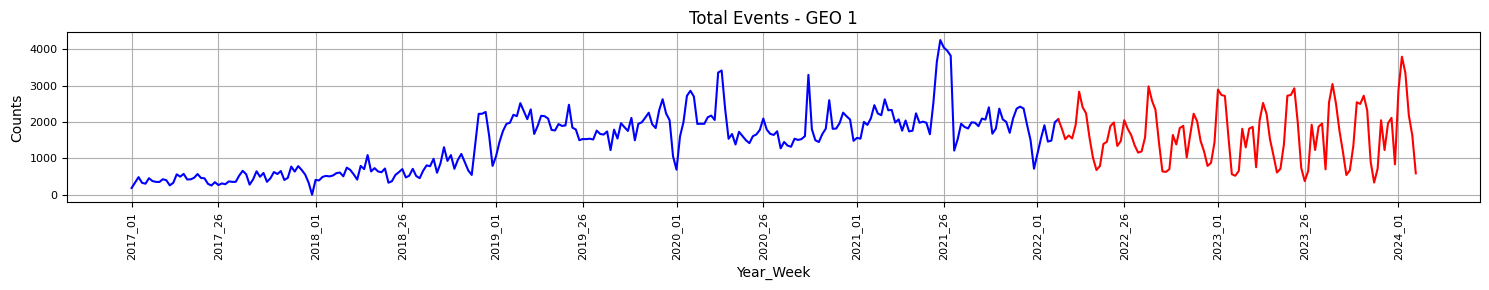

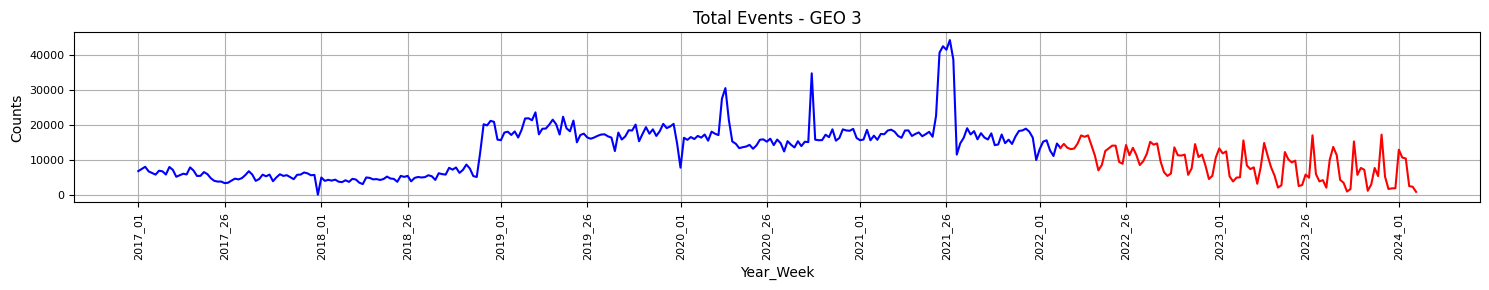

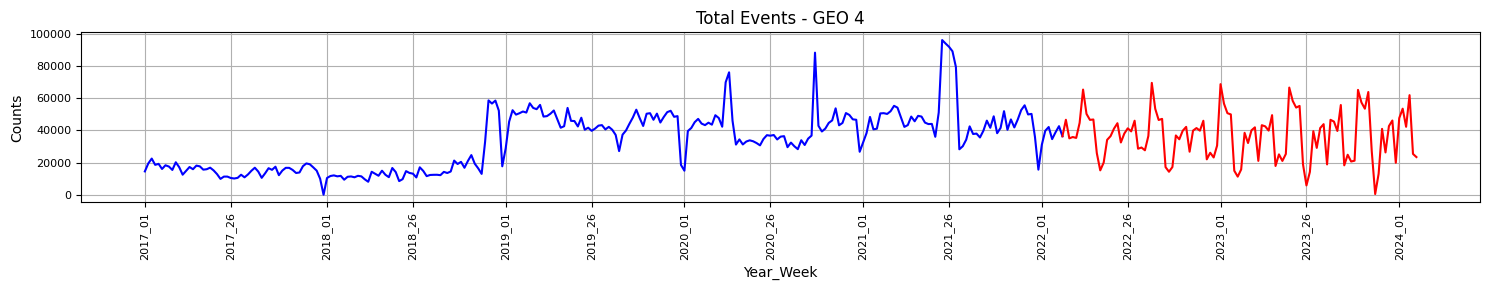

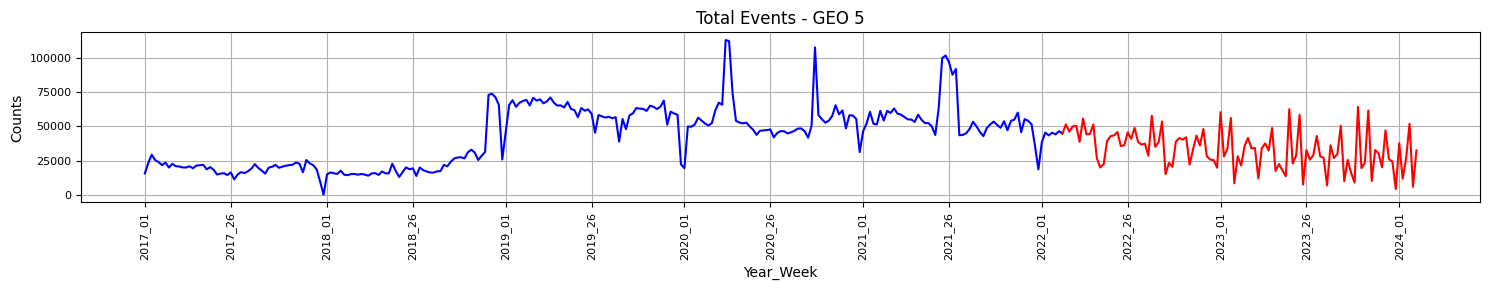

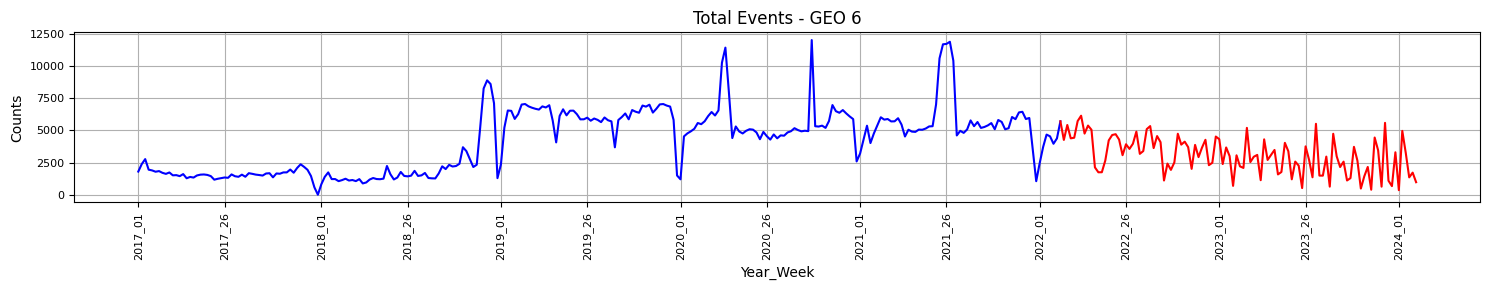

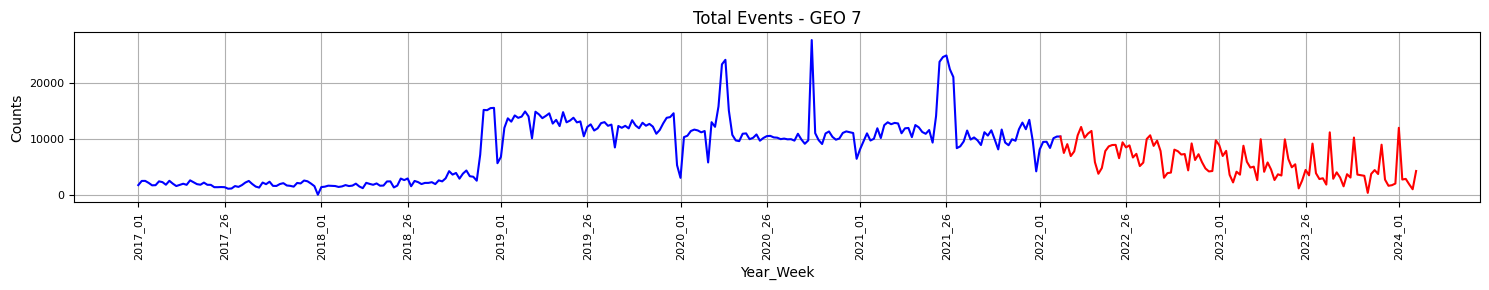

In [ ]:
def line_plot_independent_2(data, geo):
    geo_weekly = data[data['GEO'] == geo].groupby(['YEAR_WEEK']).aggregate({'TOTAL_EVENTS': 'sum', 'YEAR': 'mean', 'WEEK': 'mean'}).reset_index()

    plt.figure(figsize=(15, 3))

    # Get the index where the YEAR_WEEK value is '2022_07'
    start_index = geo_weekly[geo_weekly['YEAR_WEEK'] == '2022_07'].index[0]

    # Plot the lines before 2022_07 in one color (e.g., 'blue')
    plt.plot('YEAR_WEEK', 'TOTAL_EVENTS', data=geo_weekly.loc[:start_index], color='blue')

    # Plot the lines from 2022_07 onwards in another color (e.g., 'red')
    plt.plot('YEAR_WEEK', 'TOTAL_EVENTS', data=geo_weekly.loc[start_index:], color='red')

    plt.xlabel('Year_Week', fontsize=10)
    plt.ylabel('Counts', fontsize=10)
    plt.title(f'Total Events - GEO {geo}', fontsize=12)

    # Set the x-axis ticks to show specific intervals for clean looks
    x_ticks = ['2017_01', '2017_26', '2018_01', '2018_26', '2019_01', '2019_26', '2020_01', '2020_26', '2021_01', '2021_26', '2022_01', '2022_26', '2023_01', '2023_26', '2024_01']
    plt.xticks(ticks=x_ticks, rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Get unique GEO values
unique_geos = sorted(concatenated_df['GEO'].unique())

# Loop through each GEO and create the line plot
for geo in unique_geos:
    line_plot_independent_2(concatenated_df, geo)


***Conclusion*** Looking at results it looks like we could've used a larger sequence_length. Our model seems to focus more on short term memory as opposed to long term. If I had more time, I would have tuned it accordingly. This behaviour might be there because we tested only for 4 weeks. Model is overfitted to shorter duration and hence while it is producing good results in short term, it's performance must be average in long duration i.e. with a bigger test window (> 4 weeks). Apart from tuning hyperparameters more, and testing on larger dataset (higher sequence_length) as mentioned earlier to train and save the model. Once the model was trained, I could have tried forecasting only 1 week using past 16 etc. This would have delayed the forecasting process, but results would have been better than these.